In [3]:
import os, requests, tempfile, pickle, time
from pyhfo_detect.io import add_metadata
from pyhfo_detect.core import (ll_detect, rms_detect, morphology_detect,
                               cs_detect_beta, hilbert_detector_1_0)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 16 09:18:10 2016

Example script to detect HFO with pyhfo-detect

Script load file, detect and dump to pandas dataframe

@author: jan_cimbalnik
"""


# %% Auxiliary
def download_file(url, local_file):
    r = requests.get(url, stream=True)
    with open(local_file, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    return

# %% Get the data

# Download the data file
file_link = "https://raw.github.com/HFO-detect/HFO-detect-python/master/example_data/seeg.pkl"
local_file = tempfile.gettempdir()+'/hfo_detect_example.pkl'

download_file(file_link, local_file)

# Read the data
data_dict = pickle.load(open(local_file,'rb'))

data_arr = data_dict['data']
channels = data_dict['channels']
fsamps = data_dict['fsamp']

# Remove the file
os.remove(local_file)

# %% Presets - metadata - suggested 
met_dat = {'channel_name':"B'1", 'pat_id':'Nobody'}

data = data_arr[channels.index(met_dat['channel_name'])]
fs = fsamps[channels.index(met_dat['channel_name'])]

# %% We have data call the core of the algorithm and get detections
t = time.time()
LL_df = ll_detect(data, fs, 80, 600, 1, 0.1, 0.25)
print("Line-length detector execution time:",time.time() - t,"s")

t = time.time()
RMS_df = rms_detect(data, fs, 80, 600, 1, 0.1, 0.25)
print("RMS detector execution time:",time.time() - t,"s")

t = time.time()
Mor_df = morphology_detect(data, fs, 80, 600)
print("Morphology detector execution time:",time.time() - t,"s")

t = time.time()
CS_df = cs_detect_beta(data, fs, 80, 600, 0.1)
print("CS detector execution time:",time.time() - t,"s")

t = time.time()
Hilbert_df = hilbert_detector_1_0(data, fs, 80, 600, 3)
print("Hilbert detector execution time:",time.time() - t,"s")

# The dataframe now containes starts / stops of detections

# %% Optional conversion to uUTC time or to absolute samples in the recording

# %% Adding metadata
LL_df = add_metadata(LL_df,met_dat)
RMS_df = add_metadata(RMS_df,met_dat)
Mor_df = add_metadata(Mor_df,met_dat)
CS_df = add_metadata(CS_df,met_dat)
Hilbert_df = add_metadata(Hilbert_df,met_dat)

Line-length detector execution time: 0.1472616195678711 s
RMS detector execution time: 0.15127873420715332 s
For 30 sec, baseline length 0.0 sec
Baseline length < 2 sec, calculating for 5 min 
For 60.0 sec, baseline length 0.0 sec
ThrEnv = 1000, ThrFiltSig = 1000
!!!!Short baseline!!!!
Morphology detector execution time: 42.98818063735962 s
CS detector execution time: 16.5147385597229 s
Hilbert detector execution time: 79.6992084980011 s


In [5]:
print(RMS_df)

   event_start event_stop channel_name  pat_id
0         4000       4750          B'1  Nobody
1         6250       7250          B'1  Nobody
2         7250       8250          B'1  Nobody
3         8375       9125          B'1  Nobody
4         8750      10375          B'1  Nobody
5        11250      11875          B'1  Nobody
6        17375      18375          B'1  Nobody
7        23500      24250          B'1  Nobody
8        27375      28250          B'1  Nobody
9        30750      31625          B'1  Nobody
10       36375      37375          B'1  Nobody
11       44125      45125          B'1  Nobody
12       50500      51500          B'1  Nobody
13       54375      55375          B'1  Nobody
14       59000      59625          B'1  Nobody
15       62250      63250          B'1  Nobody
16       65875      66875          B'1  Nobody
17       70875      71875          B'1  Nobody
18       75250      75875          B'1  Nobody
19       77375      78375          B'1  Nobody
20       8150

<IPython.core.display.Javascript object>


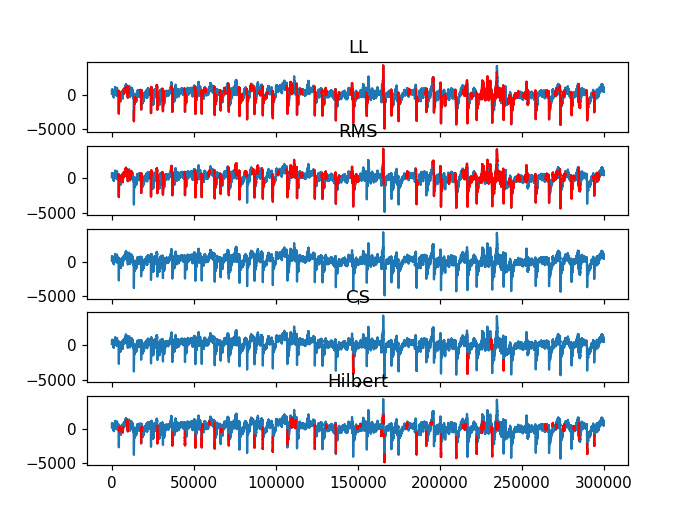

In [10]:
# %% Optional rearange columns
LL_df = LL_df.loc[:,['pat_id','channel_name','event_start','event_stop']]
RMS_df = RMS_df.loc[:,['pat_id','channel_name','event_start','event_stop']]
Mor_df = Mor_df.loc[:,['pat_id','channel_name','event_start','event_stop']]
CS_df = CS_df.loc[:,['pat_id','channel_name','event_start','event_stop']]
Hilbert_df = Hilbert_df.loc[:,['pat_id','channel_name','event_start','event_stop']]


det_dfs = [LL_df, RMS_df, Mor_df, CS_df, Hilbert_df]
det_names = ['LL','RMS','Morphology','CS','Hilbert']

f, axes_arr = plt.subplots(len(det_dfs), sharex = True, sharey= True)
for a,df, name in zip(axes_arr, det_dfs, det_names):
    a.plot(data)
    for row in df.iterrows():
        det_size = row[1].event_stop-row[1].event_start
        a.plot(np.linspace(row[1].event_start,row[1].event_stop,det_size,endpoint=False),
             data[row[1].event_start:row[1].event_stop],'r-')
        a.title.set_text(name)
plt.show()